# Collaborative Filtering

Concept of collaborative Filtering, predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating).

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/Collaborative_filtering.gif/300px-Collaborative_filtering.gif)

In this lab, we'll implement __knn__ for finding the nearest neighbors and predict rating for each project and user by using "sklern". We separate this lab to 3 parts
- Data Preparation
- Fiting Model
- Prediction to recommend next projects

Ref. https://en.wikipedia.org/wiki/Collaborative_filtering

In [1]:
# required library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
path = ''
df = pd.read_csv(path+'userLog_201801_201802_for_participants.csv', delimiter = ';', error_bad_lines = False, low_memory = False)
df.head(3)

,userCode,project_id,requestedDevice,userAgent,pageReferrer,year,month,day,hour
0,7717bdc2-ea3e-e8ad-5d6b-178bd71c38b2,7956,Mobile,Android,HomeWebsite,2018,1,1,0
1,7717bdc2-ea3e-e8ad-5d6b-178bd71c38b2,7956,Mobile,Android,HomeWebsite,2018,1,1,0
2,cb5b4b68-cc01-6db6-f54b-4a0f881301c5,5067,Mobile,iPhone,HomeWebsite,2018,1,1,0


In [4]:
# Creat a small dataset for this workshop by randomly selecting n users.
random_state = 100
sample_users = set(df['userCode'].sample(n=10000, random_state=random_state))
sample_data = df[df['userCode'].isin(sample_users)]
sample_data.head(3)

,userCode,project_id,requestedDevice,userAgent,pageReferrer,year,month,day,hour
77,3f0b3f64-468d-8411-efee-debb3facd532,8771,Desktop,Other_OS,Google,2018,1,1,0
101,6ca88f4c-0f1b-7b96-4c5b-ad3966dff12f,8439,Mobile,Android,HomeWebsite,2018,1,1,0
105,6ca88f4c-0f1b-7b96-4c5b-ad3966dff12f,8439,Mobile,Android,HomeWebsite,2018,1,1,0


### - Data Cleaning and Transformation

Create visited datetime ?

In [5]:
sample_data['datetime'] = sample_data.apply(lambda row : datetime.datetime(row['year'], row['month'], row['day'], row['hour']), axis=1)
sample_data['date'] = sample_data['datetime'].map(lambda x : x.date())
sample_data['yearmonth'] = sample_data['date'].map(lambda x: str(x.year) +'-'+ str(x.month).zfill(2))
sample_data.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

,userCode,project_id,requestedDevice,userAgent,pageReferrer,year,month,day,hour,datetime,date,yearmonth
77,3f0b3f64-468d-8411-efee-debb3facd532,8771,Desktop,Other_OS,Google,2018,1,1,0,2018-01-01,2018-01-01,2018-01
101,6ca88f4c-0f1b-7b96-4c5b-ad3966dff12f,8439,Mobile,Android,HomeWebsite,2018,1,1,0,2018-01-01,2018-01-01,2018-01
105,6ca88f4c-0f1b-7b96-4c5b-ad3966dff12f,8439,Mobile,Android,HomeWebsite,2018,1,1,0,2018-01-01,2018-01-01,2018-01


Clean data: 
- remove the projects that have less than 30 users.
There are other methods to clean the data, sometimes depending on your model.

In [6]:
min_interacted = 30
project_count = sample_data.groupby(['project_id']).size()
ignore_project = set(project_count[project_count > min_interacted].index)
print(len(ignore_project))

df_filter = sample_data[~sample_data['project_id'].isin(ignore_project)]
df_filter.head(3)

1288


,userCode,project_id,requestedDevice,userAgent,pageReferrer,year,month,day,hour,datetime,date,yearmonth
77,3f0b3f64-468d-8411-efee-debb3facd532,8771,Desktop,Other_OS,Google,2018,1,1,0,2018-01-01 00:00:00,2018-01-01,2018-01
334,16cde5e8-98ff-6be6-5f60-82bb6681673d,2096,Mobile,Android,HomeWebsite,2018,1,1,1,2018-01-01 01:00:00,2018-01-01,2018-01
338,16cde5e8-98ff-6be6-5f60-82bb6681673d,2096,Mobile,Android,HomeWebsite,2018,1,1,1,2018-01-01 01:00:00,2018-01-01,2018-01


In [ ]:
# optional, you can clean data by yourself. For example, you can remove users who have viewed less than x projects here.
df_filter = <FILL IN>

### - Split training-testing dataset
In this example, we use a date to split the data into train and test set.

In [7]:
def SplitTrainTest(df, date):
    
    df['interacted'] = 1
    df_train = df[df.date <  date]
    df_test = df[df.date >=  date].sort_values(by = ['userCode', 'datetime'])
    
    # projects which are in training datasets
    project_train = set(df_train['project_id'].values)
    df_test = df_test[df_test['project_id'].isin(project_train)]
    
    # users which are in training datasets
    user_train = set(df_train['userCode'].values)
    df_test = df_test[df_test['userCode'].isin(user_train)]
    
    print('# of train dataset:', len(df_train))
    print('# of test dataset:', len(df_test))

    return df_train, df_test

In [8]:
date_ = datetime.date(2018, 2, 20)
df_train, df_test_full = SplitTrainTest(df_filter, date = date_)

# of train dataset: 39970
# of test dataset: 2461


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Set 'userCode' as an index for convinience.
df_test_indexed = df_test_full[['userCode', 'project_id', 'interacted']].drop_duplicates().set_index('userCode')
df_test_indexed.head(3)

,project_id,interacted
userCode,,
01609e98-4aa1-40a6-cb62-5cfa8478f7e4,5883,1
02cae1e4-f73f-958e-03cd-3ca3b04b451d,7409,1
0383072a-6827-1246-6490-39fc4d46bcdd,6824,1


## Data Preparation
In this part, we'll create user-item matrix for calculating similarity between each pair of users. 
As a simple case, let's create a binary user-item matrix where 1 indicates there is an interaction (view) and 0 otherwise.
You can define the interaction values differently. Here are some examples:
- rating (no. of views) matrix
- rating (no. of views) + user profile matrix.
You can try the above options later in the workshop.

### - Case 1: 0/1 matrix
This part we'll prepare interacted data to identify interacted projects for each users. We need data like below format.
```
|------------+---+---+---+----+---|
| project_id | 1 | 2 | 3 | .. | j |
| userCode   |   |   |   |    |   |
|------------+---+---+---+----+---|
| user A     | 1 | 0 | 0 | .. | 1 |
| user B     | 0 | 1 | 0 | .. | 1 |
| user C     | 0 | 0 | 1 | .. | 0 |
|  ..        | . | . | . | .. | . |
|------------+---+---+---+----+---|

```

- 1 means that user interacted that project
- 0 means that user didn't interact that project

In [10]:
# Convert the dataframe into a matrix using pivot() and set index of df_train for fast search 
df_train_indexed = df_train[['userCode', 'project_id', 'interacted']].drop_duplicates()
df_train_pivot = (df_train_indexed.pivot(index = 'userCode', columns = 'project_id', values = 'interacted')
                                  .fillna(0))
df_train_pivot.head(3)

project_id,24,29,41,45,133,141,156,157,161,189,...,9458,9459,9460,9461,9469,9471,9474,9477,9478,9484
userCode,,,,,,,,,,,,,,,,,,,,,
00051896-b6d5-27b2-1590-6445018f084b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0009bd21-7539-62ff-f653-a6f6bac25380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0014f96a-b816-5b96-af31-e7268b46061d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_train_matrix = df_train_pivot.values
df_train_matrix.shape

(4566, 3853)

In [12]:
df_train_indexed = df_train_indexed.set_index('userCode')
df_train_indexed.head(3)

,project_id,interacted
userCode,,
3f0b3f64-468d-8411-efee-debb3facd532,8771,1
16cde5e8-98ff-6be6-5f60-82bb6681673d,2096,1
9d96b60e-0d17-2db4-4146-bb334c92e8ab,4449,1


## Implementing KNN for recommender system
In this part, we use sklearn for running a knn algorithm. For more infomation, http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

### - Fitting model

In [13]:
# import the library for building a knn model
from sklearn.neighbors import NearestNeighbors

------------------------------------------------------------------------------------------
#### Now let's use NearestNeighbor based models in sklearn to fit our data **

For more infomation, http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

------------------------------------------------------------------------------------------

In [179]:
n_neighbors = 30 # you can define number of neighbors here.
metric = 'jaccard' # you can change to other metric for calculate similarity here.

In [180]:
# Build the model
knn = NearestNeighbors(metric = metric
                        , algorithm = 'brute'
                        ,  n_neighbors = n_neighbors)

In [181]:
knn.fit(df_train_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='jaccard',
         metric_params=None, n_jobs=1, n_neighbors=30, p=2, radius=1.0)

### - Finding k nearest neighbors and get their ratings of each project
- __Input:__ user_id
- __Output:__ distance and indices of k nearest neighbors

In [182]:
user_id = '435f1a34-21ca-d605-0968-cb1b5b3f9aeb'

In [183]:
distances, indices = knn.kneighbors(df_train_pivot[df_train_pivot.index == user_id].iloc[0].values.reshape(1, -1)
                                     , n_neighbors = n_neighbors)
print('distance:', distances)
print('indices:', indices)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


distance: [[ 0.          0.          0.5         0.5         0.66666667  0.8
   0.83333333  0.875       0.95238095  0.99354839  0.9984252   1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.        ]]
indices: [[3441 1220 3405 2620 4472  997 1663 2175 2402  858 2759 3047 3060 3045
  3044 3064 3055 3056 3057 3041 3042 3053 3040 3039 3065 3038 3048 3046
  3043 3058]]


** get interacted values of k nearest neighbors by indices and calculate rating for each project.

In [184]:
k_rating_matrix = df_train_matrix[indices,]
k_rating_matrix.shape 

(1, 30, 3853)

In [185]:
k_rating = sum(k_rating_matrix)
k_weight_rating = sum(k_rating)/n_neighbors
print(k_weight_rating)
print(k_weight_rating.shape)

[ 0.  0.  0. ...,  0.  0.  0.]
(3853,)


------------------------------------------------------------------------------------------
__! TO DO: Calculate "k_weight_rating" by using distance to weight rating **__


$$ k_{weight\_rating} =\frac{ \sum  (k_{rating}\cdot \frac{1}{{distance}^2}) }{\sum\frac{1}{{distance}^2} } or \frac{ \sum  (k_{rating}\cdot {{(1-distance)}}) }{\sum{{(1-distance)}} }$$ 

------------------------------------------------------------------------------------------

In [ ]:
# optional, you can create k_weight_rating
k_weight_rating = <FILL IN>

transform to dataframe with columns 'project_id' and 'k_weight_rating'

__! TO DO: Create dataframe "recommend_df" which sort values by 'k_weight_rating' and show only topn projects. **__

In [186]:
topn = 10
recommend_df = (pd.DataFrame({"project_id": df_train_pivot.columns
                             ,"k_weight_rating": k_weight_rating})
                             .sort_values(by=['k_weight_rating'], ascending=False)
                             .head(topn))

In [187]:
recommend_df

,k_weight_rating,project_id
3410,0.366667,8644
3213,0.133333,8325
3671,0.133333,9080
1007,0.100000,4167
146,0.100000,1967
1417,0.066667,4927
2787,0.066667,7606
817,0.066667,3807
1071,0.066667,4339
821,0.066667,3816


**Recommend items before ignore interacted items: [8644, 8325, 9080, 4167, 1967, 4927, 7606]

### - Items to ignore
We'll recommend new items so we need to ignore interacted items before recommend

------------------------------------------------------------------------------------------
__! TO DO: create "get_item_interacted" function which return set of interacted items of each user and ignore them in recommend_df**__

------------------------------------------------------------------------------------------

In [188]:
def get_item_interacted(df, user_id):
    """
    Args:
    - df = dataframe which collect interacted projects of users
    - userId = user id
    
    Return:
    - set of interacted itemsets
    """
    interacted_projects = df[df.index == user_id][['project_id']] #<FILL IN>
    return set(interacted_projects['project_id'])

In [189]:
items_to_ignore = get_item_interacted(df_train_indexed, user_id)
items_to_ignore

{8644}

In [190]:
# topn = <FILL IN>
recommend_df = pd.DataFrame({"userCode": user_id
                            ,"project_id": df_train_pivot.columns
                            ,"k_weight_rating": k_weight_rating})
                             

recommend_df =  (recommend_df[~recommend_df['project_id'].isin(items_to_ignore)]
                .sort_values(by=['k_weight_rating'], ascending=False)
                             .head(topn))    

In [191]:
recommend_df

,k_weight_rating,project_id,userCode
3213,0.133333,8325,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
3671,0.133333,9080,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
1007,0.100000,4167,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
146,0.100000,1967,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
3715,0.066667,9186,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
3255,0.066667,8406,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
396,0.066667,2729,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
1057,0.066667,4312,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
2016,0.066667,6305,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
1488,0.066667,5099,435f1a34-21ca-d605-0968-cb1b5b3f9aeb


** Recommend items after ignore interacted items: [8325, 9080, 4167, 1967, 9186, 8406, 2729]

### Evaluation
We'll use metric __MAP@k__ for evaluate result.

Example of calculating MAP@5

```
|                                        |                   |        Precision       |          Average         |
|----------------------------------------+-------------------+------------------------+--------------------------|
| Actual rank: [2, 4, 1, 5]              |  [1, 0, 0, 1, 1]  | [1/1, 0, 0, 2/4, 3/5]  | (1 + 2/4 + 3/5)/4 = 0.53 |
| Recommended rank: [5, 9, 3, 1, 2]      |                   |                        |                          |
|----------------------------------------+-------------------+------------------------+--------------------------|
| Actual rank: [9, 6, 1]                 |  [1, 0, 0, 0, 0]  | [1/1, 0, 0, 2/4, 3/5]  | (1/1)/3 = 0.33           |
| Recommended rank: [9, 2, 5, 0, 4]      |                   |                        |                          |
|----------------------------------------+-------------------+------------------------+--------------------------|
| Actual rank: [6, 0, 4]                 |  [0, 0, 0, 1, 1]  | [0, 0, 0, 1/4, 2/5]    | (1/4 + 2/5)/3 = 0.22     |
| Recommended rank: [1, 10, 11, 4, 6]    |                   |                        |                          |
|----------------------------------------+-------------------+------------------------+--------------------------|
```
Mean Average Precision @ 5 = (0.53 + 0.33 + 0.22)/3 = 0.36

** It's ap for only 1 user. If you would like to evaluate all users, pls. submit file on kaggle :)

In [192]:
def ap_func(actual_list, recommend_list, k=7):
    
    m = len(actual_list)
    recoms = []
    precision = 0
    for i, item_ in enumerate(recommend_list):
        if item_ in actual_list:
            recoms.append(1)
            precision += round(sum(recoms[:i+1])/(i+1), 2)
        else:
            recoms.append(0)
          
    ap = round(precision/min(m, k), 2)
    return ap

In [193]:
actual_list = list(df_test_indexed[df_test_indexed.index == user_id]['project_id'].values)
recommend_list = list(recommend_df['project_id'].values)
ap = ap_func(actual_list, recommend_list, 7)

In [194]:
print(ap)

0.25


** ap = 0.25

#### For user_id = '435f1a34-21ca-d605-0968-cb1b5b3f9aeb'
if you follow the default values of this lab, you'll get the result like below
- recommend items before ignore interacted items: [8644, 8325, 9080, 4167, 1967, 4927, 7606]
- recommend items after ignore interacted items: [8325, 9080, 4167, 1967, 9186, 8406, 2729]
- ap = 0.25


# Create your own data preparation for recommendation

In addition to 0/1 matrix, we can using other data for user-item matrix to caculate similarity ex. rating matrix or add user profile.

### - Case 2: Rating matrix
Define rating by number of interactions with each project and scale them by bining (look at the distribution of data and define boundary)

ex. (0-1]   ==> rating = 1

    (1-2]   ==> rating = 2
    
    (2-4]   ==> rating = 3
    
    (4-7]   ==> rating = 4
    
    (7-inf] ==> rating = 5

```
|------------+---+---+---+----+---|
| project_id | 1 | 2 | 3 | .. | j |
| userCode   |   |   |   |    |   |
|------------+---+---+---+----+---|
| user A     | 4 | 0 | 0 | .. | 2 |
| user B     | 0 | 3 | 0 | .. | 1 |
| user C     | 0 | 0 | 5 | .. | 0 |
|  ..        | . | . | . | .. | . |
|------------+---+---+---+----+---|


```

------------------------------------------------------------------------------------------

#### ! TO DO: prepare rating user-item matrix like above *************************************
------------------------------------------------------------------------------------------

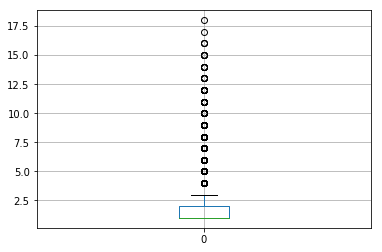

In [35]:
# distribution of number of interactions
df_train.groupby(['userCode', 'project_id']).size().reset_index()[[0]].boxplot()
plt.show()

In [33]:
# count number of interaction groupby userCode and project_id
df_train_rating = df_train.groupby(['userCode', 'project_id']).size().reset_index()
df_train_rating.head(3)

,userCode,project_id,0
0,00051896-b6d5-27b2-1590-6445018f084b,7545,4
1,0009bd21-7539-62ff-f653-a6f6bac25380,1956,1
2,0009bd21-7539-62ff-f653-a6f6bac25380,4208,2


In [38]:
max_ = df_train_rating[0].max()
bins = [1, 2, 3, 5, 7, max_]

df_train_rating['rating'] = pd.cut(df_train_rating[0], bins, right=False, labels=False)
df_train_rating['rating'] = df_train_rating['rating']+1
df_train_rating.head(3)

,userCode,project_id,0,rating
0,00051896-b6d5-27b2-1590-6445018f084b,7545,4,3.0
1,0009bd21-7539-62ff-f653-a6f6bac25380,1956,1,1.0
2,0009bd21-7539-62ff-f653-a6f6bac25380,4208,2,2.0


In [39]:
df_train_rating_pivot = (df_train_rating.pivot(index = 'userCode'
                                             ,columns = 'project_id'
                                             ,values = 'rating')
                                       .fillna(0))
df_train_rating_pivot.head(3)

project_id,24,29,41,45,133,141,156,157,161,189,...,9458,9459,9460,9461,9469,9471,9474,9477,9478,9484
userCode,,,,,,,,,,,,,,,,,,,,,
00051896-b6d5-27b2-1590-6445018f084b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0009bd21-7539-62ff-f653-a6f6bac25380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0014f96a-b816-5b96-af31-e7268b46061d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df_train_rating_matrix = df_train_rating_pivot.values
print(df_train_rating_matrix.shape)

(4566, 3853)


In [41]:
df_train_rating_index = df_train_rating.set_index(['userCode'])

### - Case 3: Rating + user profile matrix
Using above rating matrix and concat with user profile ex. weekday etc.

```
|------------+---+---+---+----+---+-----+-----+-----+-----+-----+-----+-----|
| project_id | 1 | 2 | 3 | .. | j | Mon | Tue | Wed | Thu | Fri | Sat | Sun |
| userCode   |   |   |   |    |   |     |     |     |     |     |     |     |
|------------+---+---+---+----+---|-----+-----+-----+-----+-----+-----+-----+
| user A     | 4 | 0 | 0 | .. | 2 | 0.1 | 0.3 | 0.2 | 0.0 | 0.0 | 0.1 | 0.3 |
| user B     | 0 | 3 | 0 | .. | 1 | 0.2 | 0.2 | 0.1 | 0.1 | 0.1 | 0.3 | 0.0 |
| user C     | 0 | 0 | 5 | .. | 0 | 0.0 | 0.1 | 0.1 | 0.0 | 0.0 | 0.5 | 0.3 |
|  ..        | . | . | . | .. | . | ... | ... | ... | ... | ... | ... | ... |
|------------+---+---+---+----+---+-----+-----+-----+-----+-----+-----+-----|
```


In [208]:
df_train['weekday'] = df_train['datetime'].dt.dayofweek

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [209]:
# proportion of #interactions by time interval
weekday = df_train.groupby(['userCode', 'weekday']).size()
weekday = weekday.groupby(level = 0).apply(lambda x: round(x/float(x.sum()), 2)).reset_index()
weekday.columns.values[2] = 0
user_weekday = weekday.pivot(index = 'userCode', columns = 'weekday', values = 0).fillna(0).reset_index()
user_weekday.columns =  list(user_weekday.columns.values[:1]) + ['day' + str(col) for col in user_weekday.columns.values[1:]]
user_weekday.head(3)

,userCode,day0,day1,day2,day3,day4,day5,day6
0,00051896-b6d5-27b2-1590-6445018f084b,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009bd21-7539-62ff-f653-a6f6bac25380,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0014f96a-b816-5b96-af31-e7268b46061d,1.0,0.0,0.0,0.0,0.0,0.0,0.0


------------------------------------------------------------------------------------------

#### ! TO DO: **
- create other user profile
- merge user profile and user rating
- create matrix 

------------------------------------------------------------------------------------------

In [210]:
class UserProfile:

    def __init__(self, df):
        self.df = df

    def hour(self):
        df = self.df
        time_interval = df.groupby(['userCode', 'time_interval']).size()
        time_interval = time_interval.groupby(level = 0).apply(lambda x: round(x/float(x.sum()), 2)).reset_index()
        time_interval.columns.values[2] = 0
        user_time = time_interval.pivot(index = 'userCode', columns = 'time_interval', values = 0).fillna(0).reset_index()
        return user_time

    def device(self):
        df = self.df
        device = df.groupby(['userCode', 'requestedDevice']).size()
        device = device.groupby(level = 0).apply(lambda x: round(x/float(x.sum()), 2)).reset_index()
        device.columns.values[2] = 0
        user_device = device.pivot(index = 'userCode', columns = 'requestedDevice', values = 0).fillna(0).reset_index()
        return user_device
    
    def agent(self):
        df = self.df
        agent = df.groupby(['userCode', 'userAgent']).size()
        agent = agent.groupby(level = 0).apply(lambda x: round(x/float(x.sum()), 2)).reset_index()
        agent.columns.values[2] = 0
        user_agent = agent.pivot(index = 'userCode', columns = 'userAgent', values = 0).fillna(0).reset_index()
        return user_agent
    
    def pagerefer(self):
        df = self.df
        pagerefer = df.groupby(['userCode', 'pageReferrer']).size()
        pagerefer = pagerefer.groupby(level = 0).apply(lambda x: round(x/float(x.sum()), 2)).reset_index()
        pagerefer.columns.values[2] = 0
        user_pagerefer = pagerefer.pivot(index = 'userCode', columns = 'pageReferrer', values = 0).fillna(0).reset_index()
        return user_pagerefer
    
    def all(self):
        df = self.df
        user_time = self.hour()
        print('- time --')
        user_device = self.device()
        print('- device --')
        user_agent = self.agent()
        print('- agent --')
        user_pagerefer = self.pagerefer()
        print('- pagerefer --')

        user_profile = pd.merge(user_weekday, user_time, how = 'outer', on = 'userCode')
        print('- merge --')
        user_profile = pd.merge(user_profile, user_device, how = 'outer', on = 'userCode')
        print('- merge --')
        user_profile = pd.merge(user_profile, user_agent, how = 'outer', on = 'userCode')
        print('- merge --')
        user_profile = pd.merge(user_profile, user_pagerefer, how = 'outer', on = 'userCode')
        print('- merge --')
        return user_profile


In [211]:
df_train['time_interval'] = '20-23'
df_train['time_interval'] = np.where((df_train['hour'] >= 0) & (df_train['hour'] < 9), '0-8', df_train['time_interval'])
df_train['time_interval'] = np.where((df_train['hour'] >= 9) & (df_train['hour'] < 20), '9-19', df_train['time_interval'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [212]:
User_profile = UserProfile(df_train)
user_profile = User_profile.all()
user_profile = pd.merge(user_profile, user_weekday, how='left', on=['userCode'])
user_profile.head(3)

- time --
- device --
- agent --
- pagerefer --
- merge --
- merge --
- merge --
- merge --


,userCode,day0_x,day1_x,day2_x,day3_x,day4_x,day5_x,day6_x,0-8,20-23,...,Google,HomeWebsite,Other_PageReferer,day0_y,day1_y,day2_y,day3_y,day4_y,day5_y,day6_y
0,00051896-b6d5-27b2-1590-6445018f084b,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009bd21-7539-62ff-f653-a6f6bac25380,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0014f96a-b816-5b96-af31-e7268b46061d,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [213]:
df_train_userprofile = pd.merge(df_train_pivot.reset_index()
                                , user_profile
                                , how='left'
                                , on=['userCode'])
df_train_userprofile.head(3)

,userCode,24,29,41,45,133,141,156,157,161,...,Google,HomeWebsite,Other_PageReferer,day0_y,day1_y,day2_y,day3_y,day4_y,day5_y,day6_y
0,00051896-b6d5-27b2-1590-6445018f084b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009bd21-7539-62ff-f653-a6f6bac25380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0014f96a-b816-5b96-af31-e7268b46061d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


set "userCode" to be index for fast search and create matrix user-item matrix

In [214]:
df_train_userprofile_indexed = df_train_userprofile.set_index(['userCode'])
df_train_userprofile_matrix = df_train_userprofile_indexed.values
df_train_userprofile_matrix[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

### Create function for items recommendation

In [215]:
n_neighbors = 30
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute',  n_neighbors = n_neighbors) # euclidean
model.fit(df_train_userprofile_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=30, p=2, radius=1.0)

In [219]:
def recommend_items(user_id, model, df_users, df_rating, prodect_cols, items_to_ignore=[], topn=7, n_neighbors=n_neighbors):
    
    distances, indices = model.kneighbors(df_users[df_users.index == user_id].iloc[0].values.reshape(1, -1)
                                       , n_neighbors = n_neighbors)
    
    interacted = np.zeros((n_neighbors, df_rating.shape[1]))
    n = np.zeros((n_neighbors, df_rating.shape[1]))
    
    sim = 0
    n_user = len(distances.flatten())
    for i in range(1, n_user):
        
        sim_ = 1 - distances.flatten()[i]
        sim += sim_
        rating = df_rating.loc[df_rating.index[indices.flatten()[i]]].values
        value = rating * sim
        interacted[i:i+1] += value
    
    k_weight_rating = sum(interacted)/sim
    
    recommend_df = pd.DataFrame({"project_id":prodect_cols, "k_weight_rating": k_weight_rating})
    recommend_df = (recommend_df[~recommend_df['project_id'].isin(items_to_ignore)]
                             .sort_values('k_weight_rating', ascending = False)
                             .head(topn))
    
    recommend_items = recommend_df['project_id'].values
    recommendation_df = pd.DataFrame({"userCode": user_id, "project_id": recommend_items})
    return recommendation_df, recommend_items

In [220]:
prodect_cols = df_train_pivot.columns
user_id = '435f1a34-21ca-d605-0968-cb1b5b3f9aeb'
model = model
df_users = df_train_userprofile_indexed # dataframe to select user_id to calculate similarity
df_rating = df_train_pivot # matrix to calculate weight
items_to_ignore = get_item_interacted(df_train_indexed, user_id)
recommend_df, items = recommend_items(user_id, model, df_users, df_rating, prodect_cols, items_to_ignore, 7, 30)

In [221]:
recommend_df

,project_id,userCode
0,8732,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
1,8348,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
2,4417,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
3,8833,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
4,8783,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
5,7934,435f1a34-21ca-d605-0968-cb1b5b3f9aeb
6,9059,435f1a34-21ca-d605-0968-cb1b5b3f9aeb


### Transform data for submit to kaggle

Format of dataframe for 'transform_to_kaggle' function, consist of 2 columns
- userCode
- project_id : order by sequence of recommendation (7 sequences)

```
|------------+--------------|
|  userCode  |  project_id  |
|------------+--------------|
| user A     |      4       |
| user A     |     21       |
| user A     |     34       |
|  ..        |     ..       |
```

In [195]:
def transform_to_kaggle(recommend_df):
    
    """
    Input:
        - recommed_df: userCode and project_id
    
    Returns:
        - recommed_df: 
    """
    testing_dataset = []
    recommend_df_indexed = recommend_df.set_index('userCode')
    
    for idx, user_id in enumerate(list(recommend_df_indexed.index.unique().values)):
        
        interacted_testset = recommend_df_indexed[recommend_df_indexed.index == user_id]
        rank_actual = list(interacted_testset['project_id'].values)

        if len(rank_actual) > 0:
            rank_actual_str = ' '.join(str(r) for r in rank_actual)
            testing_dataset.append({"userCode": user_id
                                   ,"project_id": rank_actual_str})
            
    testing_df = pd.DataFrame(testing_dataset)
    testing_df = testing_df[['userCode', 'project_id']]
    return testing_df

In [196]:
submit_file = transform_to_kaggle(recommend_df)

In [197]:
submit_file

,userCode,project_id
0,435f1a34-21ca-d605-0968-cb1b5b3f9aeb,8325 9080 4167 1967 9186 8406 2729 4312 6305 5099
